# M34 Data Reduction Pipeline - Simple Version

**Clean notebook for debugging and visualization**

Uses modular functions from `pipeline_utils.py` for production code.

---

## Workflow

1. Load FITS files
2. Estimate and subtract background  
3. Detect sources
4. Aperture photometry
5. Cross-match g and r bands
6. Save photometric catalog
7. **Feed catalog into membership.ipynb for filtering**

---

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import warnings
warnings.filterwarnings('ignore')

# Import pipeline utilities
from pipeline_utils import *

# Plotting
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.dpi'] = 100

print("✓ Ready to process M34 data")

✓ Pipeline utilities loaded
  Available functions:
    - load_fits_image(filepath)
    - estimate_background(data, box_size=64)
    - detect_sources(data_sub, bkg, fwhm, threshold=3.0)
    - aperture_photometry_pipeline(...)
    - cross_match_catalogs(sources_1, sources_2, wcs_1, wcs_2)
    - calculate_photometric_zeropoint(...)
    - save_catalog(catalog, filename)
✓ Ready to process M34 data


## Step 1: Load FITS Files

In [2]:
# File paths
g_file = "./Data/tfn0m436-sq33-20251018-0206-e91.fits"
r_file = "./Data/tfn0m419-sq32-20251018-0154-e91.fits"

# Load data
print("Loading FITS files...")
data_g, header_g, wcs_g = load_fits_image(g_file)
data_r, header_r, wcs_r = load_fits_image(r_file)

# Extract parameters
gain_g = header_g['GAIN']
gain_r = header_r['GAIN']
rdnoise_g = header_g['RDNOISE']
rdnoise_r = header_r['RDNOISE']
exptime_g = header_g['EXPTIME']
exptime_r = header_r['EXPTIME']
pixscale = header_g['PIXSCALE']
fwhm_g = header_g.get('L1FWHM', 2.78) / pixscale  # Convert to pixels
fwhm_r = header_r.get('L1FWHM', 2.29) / pixscale

print(f"✓ g-band: {data_g.shape} pixels, {exptime_g}s, FWHM={fwhm_g:.1f} pix")
print(f"✓ r-band: {data_r.shape} pixels, {exptime_r}s, FWHM={fwhm_r:.1f} pix")

Loading FITS files...
✓ g-band: (2400, 2400) pixels, 46.0s, FWHM=3.8 pix
✓ r-band: (2400, 2400) pixels, 79.0s, FWHM=3.1 pix


## Step 2: Background Estimation

Estimating background...
✓ g-band: median bkg = 20.4 ADU, rms = 5.6 ADU
✓ r-band: median bkg = 56.9 ADU, rms = 8.5 ADU
✓ 3-panel figure saved for paper: ./AASTeX_Template/background_panel.png


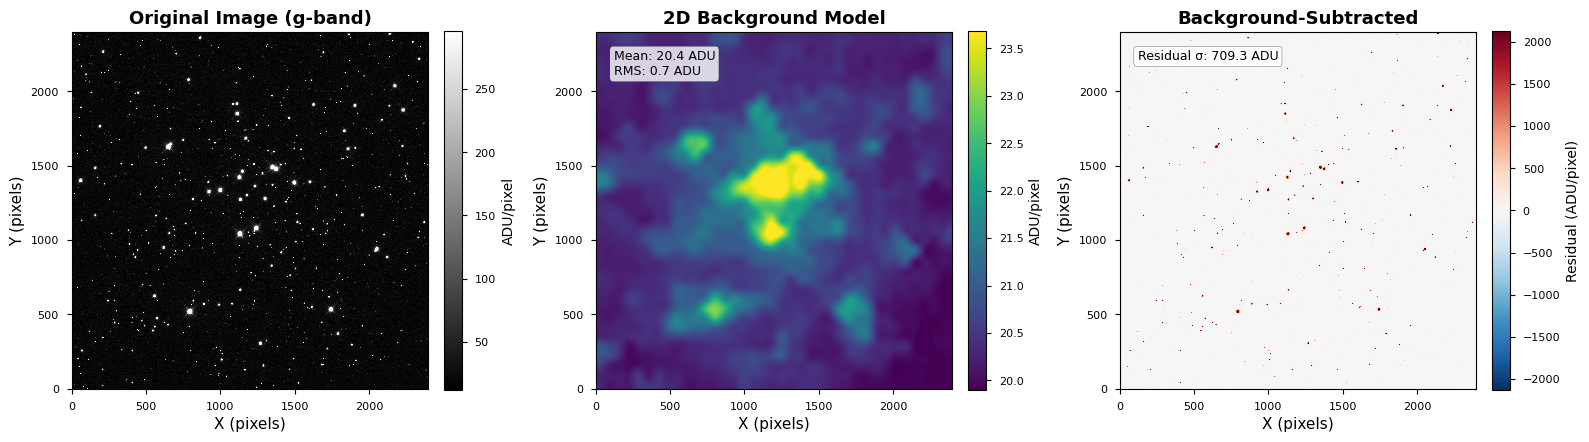

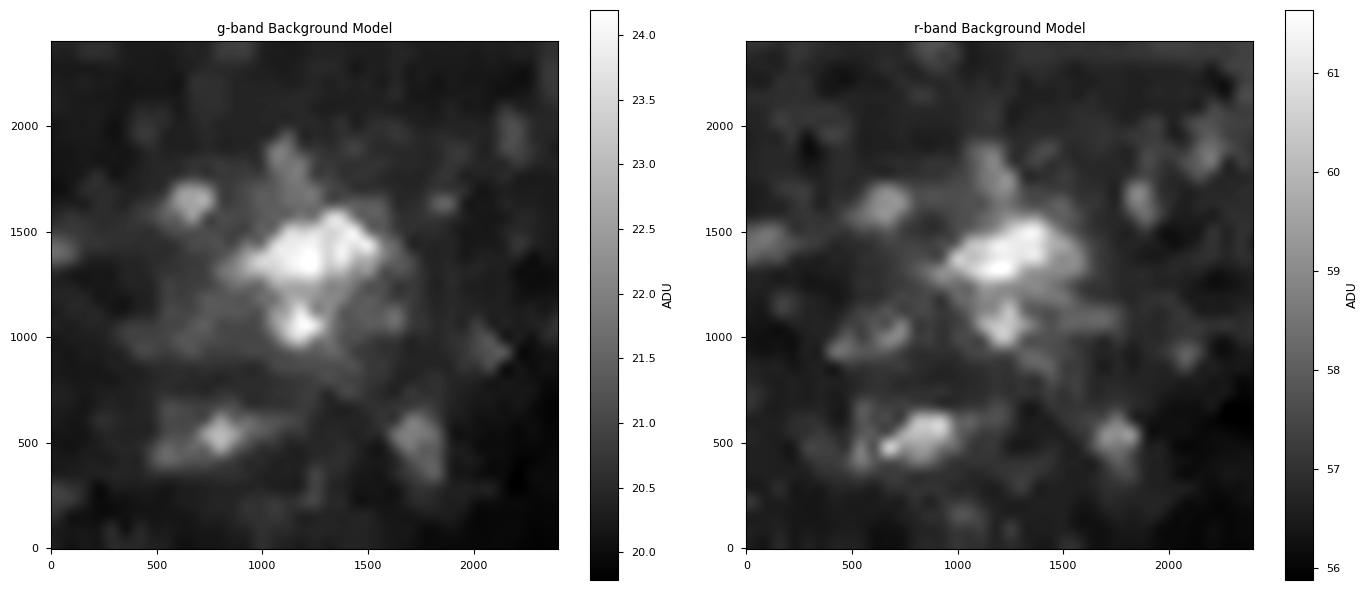

In [3]:
print("Estimating background...")
data_g_sub, bkg_g = estimate_background(data_g, box_size=64)
data_r_sub, bkg_r = estimate_background(data_r, box_size=64)

print(f"✓ g-band: median bkg = {bkg_g.background_median:.1f} ADU, rms = {bkg_g.background_rms_median:.1f} ADU")
print(f"✓ r-band: median bkg = {bkg_r.background_median:.1f} ADU, rms = {bkg_r.background_rms_median:.1f} ADU")

# Create 3-panel figure for paper (Appendix B)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Original g-band image
vmin_orig = np.percentile(data_g, 5)
vmax_orig = np.percentile(data_g, 99.5)
im1 = axes[0].imshow(data_g, origin='lower', cmap='gray',
                     vmin=vmin_orig, vmax=vmax_orig, interpolation='nearest')
axes[0].set_title('Original Image (g-band)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('X (pixels)', fontsize=11)
axes[0].set_ylabel('Y (pixels)', fontsize=11)
cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label('ADU/pixel', fontsize=10)

# Panel 2: Background model
im2 = axes[1].imshow(bkg_g.background, origin='lower', cmap='viridis',
                     vmin=np.percentile(bkg_g.background, 1),
                     vmax=np.percentile(bkg_g.background, 99),
                     interpolation='nearest')
axes[1].set_title('2D Background Model', fontsize=13, fontweight='bold')
axes[1].set_xlabel('X (pixels)', fontsize=11)
axes[1].set_ylabel('Y (pixels)', fontsize=11)
cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label('ADU/pixel', fontsize=10)

# Add statistics annotation
textstr = f'Mean: {bkg_g.background_median:.1f} ADU\nRMS: {np.std(bkg_g.background):.1f} ADU'
axes[1].text(0.05, 0.95, textstr, transform=axes[1].transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Panel 3: Background-subtracted image
vmin_sub = -3 * np.std(data_g_sub)
vmax_sub = 3 * np.std(data_g_sub)
im3 = axes[2].imshow(data_g_sub, origin='lower', cmap='RdBu_r',
                     vmin=vmin_sub, vmax=vmax_sub, interpolation='nearest')
axes[2].set_title('Background-Subtracted', fontsize=13, fontweight='bold')
axes[2].set_xlabel('X (pixels)', fontsize=11)
axes[2].set_ylabel('Y (pixels)', fontsize=11)
cbar3 = plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
cbar3.set_label('Residual (ADU/pixel)', fontsize=10)

# Add residual RMS annotation
textstr_sub = f'Residual σ: {np.std(data_g_sub):.1f} ADU'
axes[2].text(0.05, 0.95, textstr_sub, transform=axes[2].transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('./AASTeX_Template/background_panel.png', dpi=300, bbox_inches='tight')
print(f"✓ 3-panel figure saved for paper: ./AASTeX_Template/background_panel.png")
plt.show()

# Also show r-band for comparison
fig2, axes2 = plt.subplots(1, 2, figsize=(14, 6))
ax = axes2[0]
im = ax.imshow(bkg_g.background, origin='lower', cmap='gray')
ax.set_title('g-band Background Model')
plt.colorbar(im, ax=ax, label='ADU')

ax = axes2[1]
im = ax.imshow(bkg_r.background, origin='lower', cmap='gray')
ax.set_title('r-band Background Model')
plt.colorbar(im, ax=ax, label='ADU')
plt.tight_layout()
plt.show()

## Step 3: Source Detection

In [4]:
print("Detecting sources...")
sources_g = detect_sources(data_g_sub, bkg_g, fwhm=fwhm_g, threshold=3.0)
sources_r = detect_sources(data_r_sub, bkg_r, fwhm=fwhm_r, threshold=3.0)

print(f"✓ g-band: {len(sources_g)} sources detected")
print(f"✓ r-band: {len(sources_r)} sources detected")

# Show brightest sources
print(f"\nBrightest 5 stars (g-band):")
print(sources_g['id', 'xcentroid', 'ycentroid', 'flux', 'mag_inst'][:5])

Detecting sources...
✓ g-band: 10981 sources detected
✓ r-band: 10873 sources detected

Brightest 5 stars (g-band):
 id      xcentroid      ...        flux              mag_inst     
---- ------------------ ... ------------------ -------------------
2347  1739.909424783722 ...  1019729.991450878 -15.021212981497163
4762 1237.9528290716673 ... 1015602.8483075884 -15.016809775508479
6733  1371.912574459812 ... 1004863.5205765925 -15.005267700944895
7479  647.9825820056383 ... 1003201.8129555822 -15.003470770827583
6252  1493.982954616565 ...  988073.3370771656  -14.98697295029983


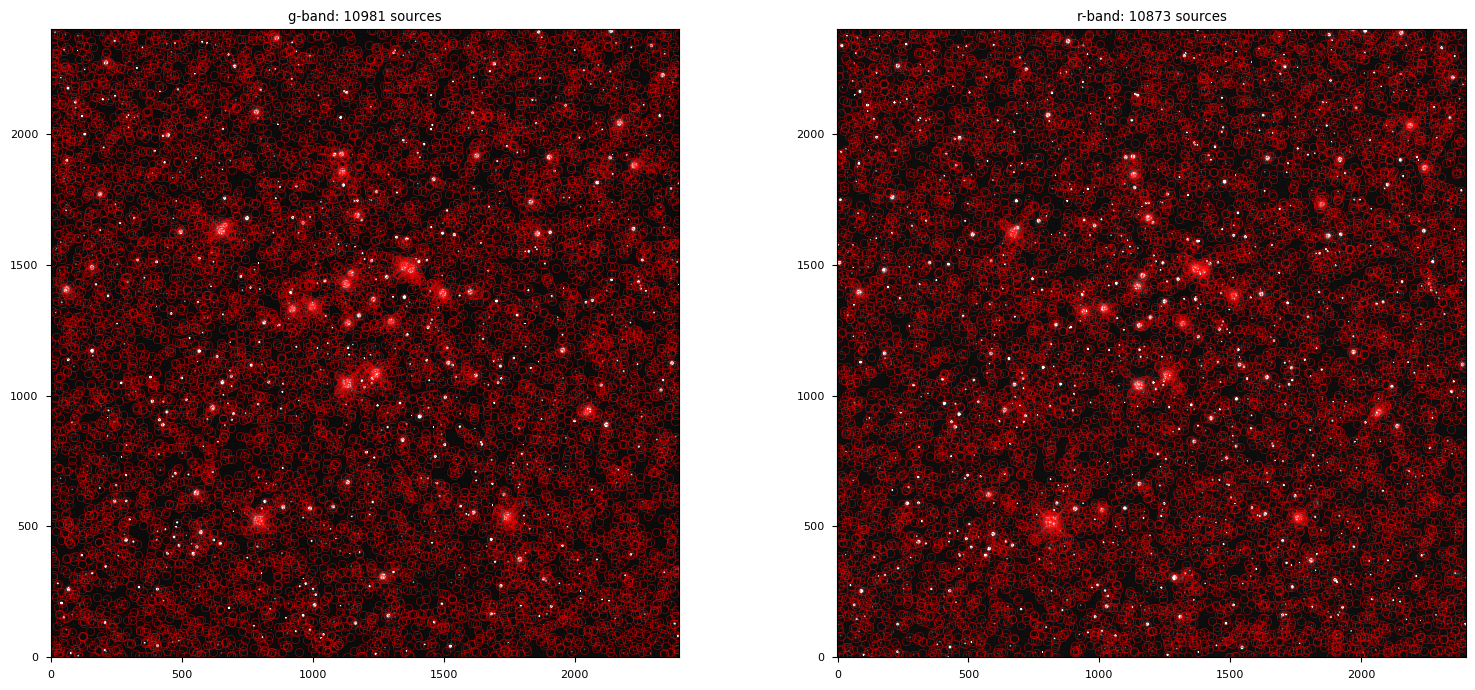

In [5]:
# Visualize detections
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

ax = axes[0]
vmin, vmax = np.percentile(data_g_sub, [1, 99.5])
ax.imshow(data_g_sub, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.plot(sources_g['xcentroid'], sources_g['ycentroid'], 'ro', 
        fillstyle='none', markersize=6, markeredgewidth=0.5, alpha=0.5)
ax.set_title(f'g-band: {len(sources_g)} sources')

ax = axes[1]
vmin, vmax = np.percentile(data_r_sub, [1, 99.5])
ax.imshow(data_r_sub, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.plot(sources_r['xcentroid'], sources_r['ycentroid'], 'ro',
        fillstyle='none', markersize=6, markeredgewidth=0.5, alpha=0.5)
ax.set_title(f'r-band: {len(sources_r)} sources')

plt.tight_layout()
plt.show()

## Step 4: Aperture Photometry

In [6]:
# Aperture parameters (1.5 x FWHM for aperture, sky annulus beyond)
aper_radius_g = 1.5 * fwhm_g
aper_radius_r = 1.5 * fwhm_r
annulus_inner = 2.5 * np.mean([fwhm_g, fwhm_r])
annulus_outer = 4.0 * np.mean([fwhm_g, fwhm_r])

print("Performing aperture photometry...")
print(f"  g-band aperture radius: {aper_radius_g:.1f} pixels")
print(f"  r-band aperture radius: {aper_radius_r:.1f} pixels")
print(f"  Sky annulus: {annulus_inner:.1f} - {annulus_outer:.1f} pixels\n")

# Do photometry
phot_g = aperture_photometry_pipeline(data_g_sub, sources_g, aper_radius_g,
                                       annulus_inner, annulus_outer,
                                       gain_g, rdnoise_g, exptime_g)

phot_r = aperture_photometry_pipeline(data_r_sub, sources_r, aper_radius_r,
                                       annulus_inner, annulus_outer,
                                       gain_r, rdnoise_r, exptime_r)

print(f"✓ Photometry complete")
print(f"\nSample photometry (g-band):")
print(phot_g['xcenter', 'ycenter', 'flux_aper', 'flux_err', 'mag_inst', 'mag_err'][:5])

Performing aperture photometry...
  g-band aperture radius: 5.6 pixels
  r-band aperture radius: 4.6 pixels
  Sky annulus: 8.6 - 13.7 pixels

✓ Photometry complete

Sample photometry (g-band):
     xcenter            ycenter       ...        mag_err       
------------------ ------------------ ... ---------------------
 1739.909424783722  534.9315199752507 ... 0.0006599212902259577
1237.9528290716673 1081.9836869943765 ... 0.0006447090283156775
 1371.912574459812 1479.9395266328236 ... 0.0006664111587235273
 647.9825820056383  1628.004634394811 ... 0.0006373346138405394
 1493.982954616565 1387.6011285267239 ... 0.0007248354284332356


## Step 5: Cross-Match g and r Bands

In [7]:
print("Cross-matching g and r catalogs...")
idx_g, idx_r, sep = cross_match_catalogs(sources_g, sources_r, wcs_g, wcs_r, max_sep_arcsec=2.0)

print(f"✓ {len(idx_g)} sources matched (sep < 2 arcsec)")
print(f"  Median separation: {np.median(sep.arcsec):.2f} arcsec")

# Create matched catalog
from astropy.table import hstack

# Get matched entries
matched_g = sources_g[idx_g]
matched_r = sources_r[idx_r]
matched_phot_g = phot_g[idx_g]
matched_phot_r = phot_r[idx_r]

# Combine
catalog = Table()
catalog['x'] = matched_g['xcentroid']
catalog['y'] = matched_g['ycentroid']
catalog['g_inst'] = matched_phot_g['mag_inst']
catalog['g_err'] = matched_phot_g['mag_err']
catalog['r_inst'] = matched_phot_r['mag_inst']
catalog['r_err'] = matched_phot_r['mag_err']
catalog['g_minus_r'] = catalog['g_inst'] - catalog['r_inst']

# Add RA, Dec from WCS
coords = wcs_g.pixel_to_world(catalog['x'], catalog['y'])
catalog['ra'] = coords.ra.deg
catalog['dec'] = coords.dec.deg

print(f"\nFinal catalog: {len(catalog)} sources with g and r photometry")
print(catalog[:5])

Cross-matching g and r catalogs...
✓ 2888 sources matched (sep < 2 arcsec)
  Median separation: 0.57 arcsec

Final catalog: 2888 sources with g and r photometry
        x                  y          ...         ra               dec        
------------------ ------------------ ... ----------------- ------------------
 1739.909424783722  534.9315199752507 ... 40.38308831095794   42.5940926027774
1237.9528290716673 1081.9836869943765 ... 40.52424646825692 42.707352809216914
 1371.912574459812 1479.9395266328236 ... 40.48650874571176  42.78971106618661
 647.9825820056383  1628.004634394811 ... 40.69075175580226  42.82018633233686
 1493.982954616565 1387.6011285267239 ... 40.45209844399112  42.77059437293968


## Step 6: Quality Checks & Visualization

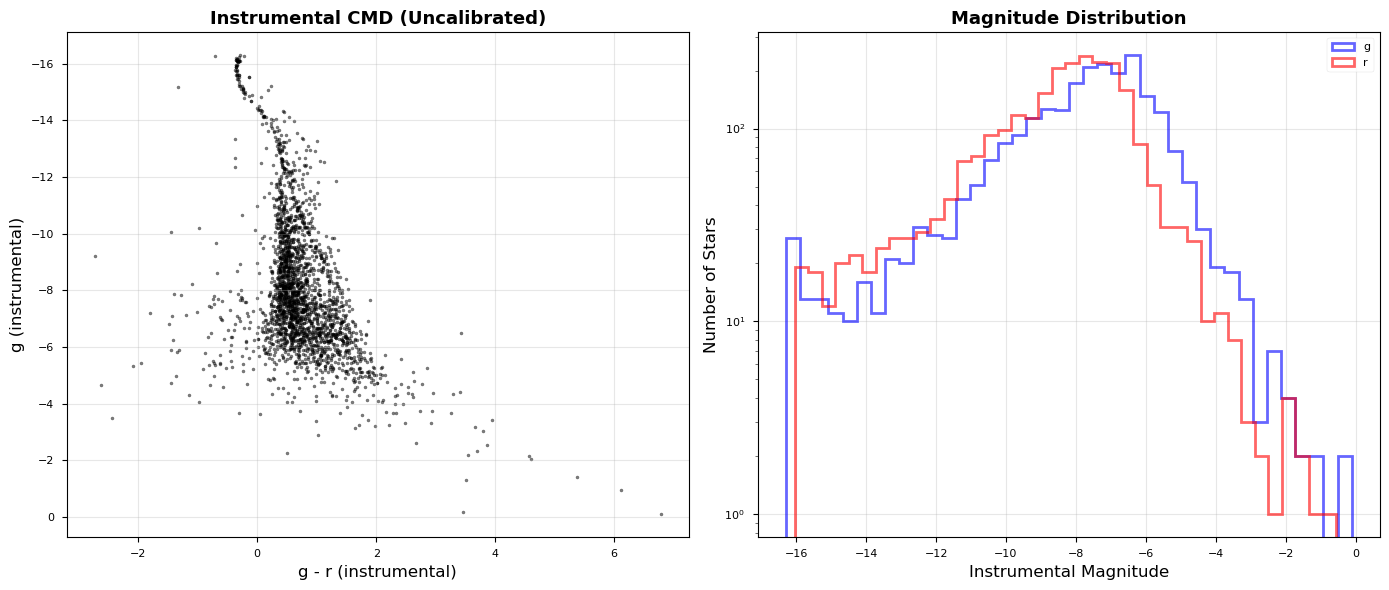


Magnitude range:
  g: nan to nan
  r: nan to nan
  g-r: nan to nan


In [8]:
# Color-magnitude diagram (uncalibrated)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# CMD
ax = axes[0]
ax.scatter(catalog['g_minus_r'], catalog['g_inst'], s=5, alpha=0.5, c='black')
ax.set_xlabel('g - r (instrumental)', fontsize=12)
ax.set_ylabel('g (instrumental)', fontsize=12)
ax.set_title('Instrumental CMD (Uncalibrated)', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(alpha=0.3)

# Magnitude histograms
ax = axes[1]
ax.hist(catalog['g_inst'], bins=40, alpha=0.6, label='g', color='blue', histtype='step', lw=2)
ax.hist(catalog['r_inst'], bins=40, alpha=0.6, label='r', color='red', histtype='step', lw=2)
ax.set_xlabel('Instrumental Magnitude', fontsize=12)
ax.set_ylabel('Number of Stars', fontsize=12)
ax.set_title('Magnitude Distribution', fontsize=13, fontweight='bold')
ax.legend()
ax.set_yscale('log')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMagnitude range:")
print(f"  g: {catalog['g_inst'].min():.1f} to {catalog['g_inst'].max():.1f}")
print(f"  r: {catalog['r_inst'].min():.1f} to {catalog['r_inst'].max():.1f}")
print(f"  g-r: {catalog['g_minus_r'].min():.2f} to {catalog['g_minus_r'].max():.2f}")

## Step 7: Save Catalog

In [9]:
# Save to CSV for use in membership.ipynb
output_file = "m34_photometry_instrumental.csv"
save_catalog(catalog, output_file, format='csv')

print(f"\n✓ Pipeline complete!")
print(f"\nNext steps:")
print(f"  1. Load this catalog in membership.ipynb")
print(f"  2. Apply CMD, proper motion, and spatial filtering")
print(f"  3. Identify M34 cluster members")
print(f"  4. Calibrate photometry using Gaia or Pan-STARRS")
print(f"  5. Build density profile in density_profile.ipynb")

✓ Catalog saved to m34_photometry_instrumental.csv

✓ Pipeline complete!

Next steps:
  1. Load this catalog in membership.ipynb
  2. Apply CMD, proper motion, and spatial filtering
  3. Identify M34 cluster members
  4. Calibrate photometry using Gaia or Pan-STARRS
  5. Build density profile in density_profile.ipynb
